<a href="https://colab.research.google.com/github/minshyee/CP1/blob/main/mdoel_sentiment_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
origin = pd.read_csv('/content/drive/MyDrive/AIBootCamp/cp1/new_ctrain_df.csv')
origin.drop('Unnamed: 0', axis=1, inplace=True)
origin

,text,leng,tokens,target,cnt_tokens
0,going kill sooni dont know know body mind comp...,250,"['going', 'kill', 'sooni', 'know', 'know', 'bo...",1,37
1,sub diary day 68 today great school stuff basi...,130,"['sub', 'diary', 'day', '68', 'today', 'great'...",0,22
2,supposed doive got problem years antisocial da...,710,"['supposed', 'doive', 'got', 'problem', 'years...",1,100
3,hey yes need help new subreddit ground subredd...,181,"['hey', 'yes', 'need', 'help', 'new', 'subredd...",0,23
4,non trans gender dysphoria like menstruation e...,420,"['non', 'trans', 'gender', 'dysphoria', 'like'...",0,53
...,...,...,...,...,...
182129,found combo steve minecraft forgot save vault ...,111,"['found', 'combo', 'steve', 'minecraft', 'forg...",0,18
182130,hate admit california texas similar loyalty yo...,264,"['hate', 'admit', 'california', 'texas', 'simi...",0,35
182131,people online 20000 horny mf time whats guys,44,"['people', 'online', '20000', 'horny', 'mf', '...",0,8
182132,fuck chemistry man gotta study thing wanna lif...,56,"['fuck', 'chemistry', 'man', 'gotta', 'study',...",0,10


### test data preprocessing

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/AIBootCamp/cp1/train_data.csv')
test.drop('Unnamed: 0', axis=1, inplace=True)
test

,text,leng,tokens,target
0,going kill sooni dont know know body mind comp...,41,"['going', 'kill', 'sooni', 'know', 'know', 'bo...",1
1,sub diary day 68 today great school stuff basi...,22,"['sub', 'diary', 'day', '68', 'today', 'great'...",0
2,supposed doive got problem years antisocial da...,109,"['supposed', 'doive', 'got', 'problem', 'years...",1
3,hey yes need help new subreddit ground subredd...,23,"['hey', 'yes', 'need', 'help', 'new', 'subredd...",0
4,non trans gender dysphoria like menstruation e...,55,"['non', 'trans', 'gender', 'dysphoria', 'like'...",0
...,...,...,...,...
185654,found combo steve minecraft forgot save vault ...,19,"['found', 'combo', 'steve', 'minecraft', 'forg...",0
185655,hate admit california texas similar loyalty yo...,35,"['hate', 'admit', 'california', 'texas', 'simi...",0
185656,people online 20000 horny mf time whats guys,8,"['people', 'online', '20000', 'horny', 'mf', '...",0
185657,fuck chemistry man gotta study thing wanna lif...,10,"['fuck', 'chemistry', 'man', 'gotta', 'study',...",0


In [ ]:
test.isnull().sum()

text      55
leng       0
tokens     0
target     0
dtype: int64

In [ ]:
test.dropna(inplace=True)

In [ ]:
test.isnull().sum()

text      0
leng      0
tokens    0
target    0
dtype: int64

In [ ]:
test['leng'] = test.text.apply(lambda x: len(x))
test = test[test['leng']>15].reset_index(drop=True)

In [ ]:
import ast # list convert
def convert_lst(x):
  x = ast.literal_eval(x)
  return len(x)

In [ ]:
test['cnt_tokens'] = test.tokens.apply(convert_lst)
test = test[test['cnt_tokens']>3]

In [ ]:
test_X = test.drop('target', axis=1)
test_y = test['target']

test_X.shape, test_y.shape

((182134, 4), (182134,))

In [ ]:
df = origin.copy()

In [ ]:
train_X = df.drop('target', axis=1)
train_y = df['target']

train_X.shape, train_y.shape

((182134, 4), (182134,))

# LSTM


In [ ]:
import tensorflow as tf
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Dropout,Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


In [ ]:
tokenizer=Tokenizer()

In [ ]:
train_text_seq=tokenizer.texts_to_sequences(df['text'])
train_text_pad=pad_sequences(train_text_seq,maxlen=50)

#test
test_text_seq=tokenizer.texts_to_sequences(test_X['text'])
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [ ]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_y)
test_output=lbl_target.transform(test_y)

## callback

In [ ]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

## Glove 훈련


In [ ]:
!pip install glove_python_binary

     |████████████████████████████████| 948 kB 8.8 MB/s 


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7fe2d4003290>)

In [ ]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [ ]:
%%time
from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(result, window=5)
glove = Glove(no_components=100, learning_rate=0.05)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
CPU times: user 3min 53s, sys: 270 ms, total: 3min 53s
Wall time: 2min 6s


In [ ]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

## Model

In [ ]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(128,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 300)           300       
                                                                 
 lstm_11 (LSTM)              (None, 50, 128)           219648    
                                                                 
 global_max_pooling1d_11 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                     

In [ ]:
%%time
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=50,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/50
712/712 [==============================] - 381s 533ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6931 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 2/50
712/712 [==============================] - 372s 522ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 3/50
712/712 [==============================] - 368s 516ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 4/50
712/712 [==============================] - 371s 522ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 5/50
712/712 [==============================] - 361s 508ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5051 - lr: 1.0000e-04
Epoch 6/50
712/712 [==============================] - 366s 514ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5051 - lr: 1.0000e-04
Epoch 7/50
712/712 [==================

In [ ]:
import matplotlib.pyplot as plt


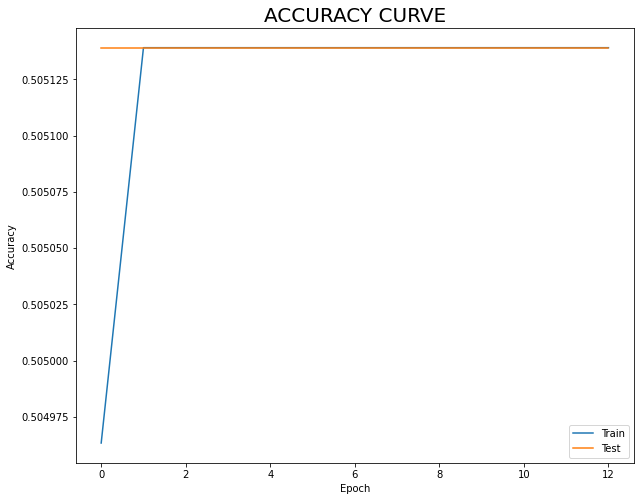

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

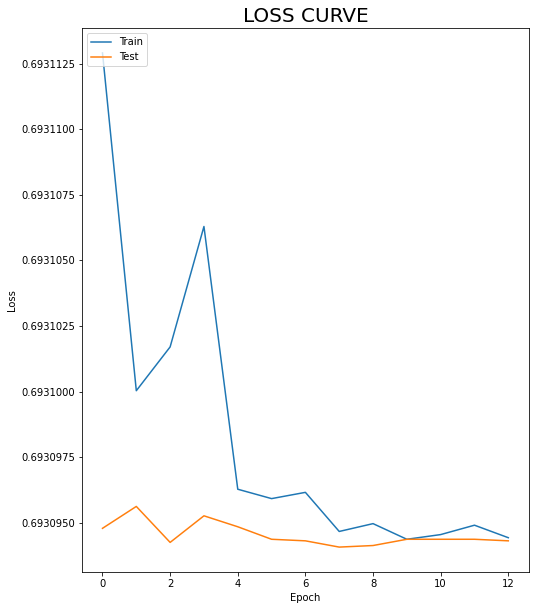

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.predict(test_text_pad)

array([[0.50528246],
       [0.50528246],
       [0.50528246],
       ...,
       [0.50528246],
       [0.50528246],
       [0.50528246]], dtype=float32)

In [ ]:
import pickle
with open('model_mine.pkl','wb') as pickle_file:
    pickle.dump(model, pickle_file)

INFO:tensorflow:Assets written to: ram://895b8452-0837-4fc8-9f6c-771d11f8b04f/assets


INFO:tensorflow:Assets written to: ram://895b8452-0837-4fc8-9f6c-771d11f8b04f/assets


# NLTK vador

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
train_X.shape

(182134, 4)

In [ ]:
train_X.index[182133:]

RangeIndex(start=182133, stop=182134, step=1)

In [ ]:
sa = SentimentIntensityAnalyzer()
sample_review = train_X.text[:2]
p=[]
for test in sample_review:
  print(type(test))
  p.append(sa.polarity_scores(test)['compound'])

<class 'str'>
<class 'str'>


In [ ]:
sa = SentimentIntensityAnalyzer()
sample_review = train_X.text[:2
p=[]
for test in sample_review:
  print
  p.append(sa.polarity_scores(test)['compound'])
p

[-0.0156,
 0.128,
 -0.9937,
 0.8524,
 -0.0353,
 0.1027,
 -0.9524,
 0.0,
 -0.7964,
 -0.91,
 -0.1041,
 -0.9611,
 0.8599,
 0.0,
 -0.4519,
 0.9883,
 -0.5883,
 0.5719,
 -0.2732,
 0.7269,
 0.4019,
 -0.9947,
 0.8225,
 -0.9991,
 -0.9219,
 -0.567,
 -0.9906,
 0.3182,
 -0.969,
 0.8316,
 0.9371,
 -0.8624,
 0.8591,
 0.7598,
 -0.25,
 -0.9794,
 -0.9968,
 -0.9677,
 -0.9797,
 -0.6329,
 -0.9274,
 -0.4404,
 0.836,
 0.2354,
 0.8565,
 0.7269,
 -0.8851,
 0.2862,
 -0.7003,
 -0.9081,
 -0.9943,
 0.9961,
 -0.7371,
 0.9853,
 -0.0772,
 0.8225,
 -0.9511,
 -0.9792,
 0.0,
 0.0258,
 -0.25,
 -0.7548,
 -0.9957,
 0.7153,
 -0.7337,
 0.6234,
 -0.8389,
 0.296,
 -0.1531,
 0.6573,
 -0.9853,
 0.1779,
 0.8936,
 -0.484,
 -0.9641,
 -0.8834,
 -0.5423,
 0.0,
 -0.9325,
 0.8261,
 -0.4482,
 -0.9916,
 0.4019,
 -0.9168,
 0.9718,
 -0.9566,
 -0.765,
 0.9003,
 0.9515,
 0.9868,
 0.4588,
 -0.9904,
 0.0,
 -0.3318,
 0.0,
 -0.9062,
 0.0,
 -0.0258,
 0.0,
 0.6129,
 0.3129,
 0.4939,
 -0.0757,
 -0.9904,
 -0.9624,
 -0.6705,
 0.6343,
 0.9167,
 -0.45

In [ ]:
train_X['score'] = p

In [ ]:
train_X.describe()

,leng,cnt_tokens,score
count,182134.000000,182134.000000,182134.000000
mean,366.047267,52.716753,-0.132443
std,623.818550,91.293974,0.693508
min,16.000000,4.000000,-1.000000
25%,81.000000,12.000000,-0.845200
50%,175.000000,25.000000,-0.177900
75%,423.000000,61.000000,0.532100
max,40014.000000,5717.000000,1.000000


In [ ]:
import pickle
with open('model_vader.pkl','wb') as pickle_file:
    pickle.dump(sa, pickle_file)